In [ ]:
# Install Keras Hub for Vision Transformer models
!pip install -q git+https://github.com/keras-team/keras-hub.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**ViT Model**

In [ ]:
import os
import shutil
import glob
import numpy as np
import tensorflow as tf
import keras
import keras_hub
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set backend to JAX
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
keras.utils.set_random_seed(42)

In [ ]:
if not os.path.exists("CarInBikeLane"):
    !git clone https://github.com/riya21parikh/CarInBikeLane.git

root = "/content/CarInBikeLane/Method1/data/data"
root2 = "/content/CarInBikeLane/Method1/data/data2"
root3 = "/content/CarInBikeLane/Method2/Bikelanes"

#combining all source folders into two lists: blocked and notblocked
blocked_folders = [
    os.path.join(root, "blocked2"),
    os.path.join(root2, "blocked3"),
    os.path.join(root3, "blocked")
]

notblocked_folders = [
    os.path.join(root, "notblocked2"),
    os.path.join(root2, "notblocked3"),
    os.path.join(root3, "notblocked")
]

blocked_files = []
notblocked_files = []

for folder in blocked_folders:
    if os.path.exists(folder):
        blocked_files += [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]

for folder in notblocked_folders:
    if os.path.exists(folder):
        notblocked_files += [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]

print(f"Total blocked images: {len(blocked_files)}")
print(f"Total notblocked images: {len(notblocked_files)}")

Total blocked images: 2351
Total notblocked images: 1831


In [ ]:
# Helper function to identify the camera from the filename
def is_cam68(path):
    return "cam68" in os.path.basename(path)

# Create Train/Val/Test Splits
# Test Set: All images from cam68
test_blocked = [f for f in blocked_files if is_cam68(f)]
test_notblocked = [f for f in notblocked_files if is_cam68(f)]

# Remaining images (cam31, cam135, cam182) are available for training
blocked_remaining = [f for f in blocked_files if f not in test_blocked]
notblocked_remaining = [f for f in notblocked_files if f not in test_notblocked]

# Split remaining into Train (70%) and Validation (30%)
# fixed seed for reproducibility
train_blocked, val_blocked = train_test_split(blocked_remaining, test_size=0.3, random_state=42)
train_notblocked, val_notblocked = train_test_split(notblocked_remaining, test_size=0.3, random_state=42)

# Organize into a clean directory structure for Keras
# This allows us to use `image_dataset_from_directory` easily
BASE_DIR = "/content/split_camera_vit"
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

for split in ["train", "val", "test"]:
    for cls in ["blocked", "notblocked"]:
        os.makedirs(os.path.join(BASE_DIR, split, cls), exist_ok=True)

# Copy files function
def copy_files(files, split, cls):
    for f in files:
        shutil.copy(f, os.path.join(BASE_DIR, split, cls))

copy_files(train_blocked, "train", "blocked")
copy_files(train_notblocked, "train", "notblocked")
copy_files(val_blocked, "val", "blocked")
copy_files(val_notblocked, "val", "notblocked")
copy_files(test_blocked, "test", "blocked")
copy_files(test_notblocked, "test", "notblocked")

print("Dataset organized in:", BASE_DIR)

Dataset organized in: /content/split_camera_vit


**Creating Keras Dataset**\
Converting the image files into TensorFlow datasets. Resizing images to 224x224 because standard pre-trained ViT models expect this resolution.

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets using Keras utility
train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(BASE_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary', # 0 for blocked, 1 for notblocked
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(BASE_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

test_ds = keras.utils.image_dataset_from_directory(
    os.path.join(BASE_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

# Print class names to verify mapping (e.g., ['blocked', 'notblocked'])
print("Class names:", train_ds.class_names)

Found 2774 files belonging to 2 classes.
Found 1225 files belonging to 2 classes.
Found 38 files belonging to 2 classes.
Class names: ['blocked', 'notblocked']


**Building the ViT Model**

Augmentation: Random flips/rotations to prevent overfitting (important since we only have ~4k images).

Preprocessing: Normalizes pixel values for the specific pre-trained model.

Backbone: The pre-trained ViT (Base, Patch16, 224).

Classifier Head: A dense layer to make the final binary decision.

In [ ]:
# Augmentation Pipeline
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal", seed=42),
        keras.layers.RandomRotation(factor=0.02, seed=42),
        keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=42)
    ],
    name="data_augmentation",
)

# Load Pretrained ViT Backbone and Preprocessor
# using 'vit_base_patch16_224' trained on ImageNet
backbone_name = "vit_base_patch16_224_imagenet"
preprocessor = keras_hub.models.ViTImageClassifierPreprocessor.from_preset(backbone_name)
backbone = keras_hub.models.ViTBackbone.from_preset(backbone_name)

# Freeze the backbone initially (Transfer Learning Best Practice)
# only want to train the final classifier layer first
backbone.trainable = False

# Construct the Functional Model
inputs = keras.Input(shape=(224, 224, 3))

# Apply augmentation
x = data_augmentation(inputs)

# Preprocess (normalize pixels, etc.)
x = preprocessor(x)

# Pass through ViT Backbone
x = backbone(x)

# The ViT output shape is (batch_size, sequence_length, hidden_dim)
# taking the "CLS" token, which is usually at index 0, representing the whole image
x = x[:, 0, :]

# Classification Head
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x) # Regularization
outputs = keras.layers.Dense(1, activation="sigmoid")(x) # Binary output

model = keras.Model(inputs, outputs, name="vit_classifier")

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "vit_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_image_classifier_preproce… │ (None, 224, 224, 3)    │             0 │
│ (ViTImageClassifierPreprocesso… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_backbone (ViTBackbone)     │ (None, 197, 768)       │    85,798,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,897,217 (327.67 MB)

 Trainable params: 98,561 (385.00 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

**Training & Evaluation** \
We train the model using Early Stopping to prevent overfitting.

In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_vit_model.keras", save_best_only=True)
]

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.5300 - loss: 0.7561 - val_accuracy: 0.5976 - val_loss: 0.6601
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.6150 - loss: 0.6571 - val_accuracy: 0.6310 - val_loss: 0.6314
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.6350 - loss: 0.6270 - val_accuracy: 0.6441 - val_loss: 0.6191
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.6550 - loss: 0.6170 - val_accuracy: 0.6351 - val_loss: 0.6271
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.6742 - loss: 0.6030 - val_accuracy: 0.6669 - val_loss: 0.5920
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.6756 - loss: 0.5993 - val_accuracy: 0.6873 - val_loss: 0.5756
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.7023 - loss: 0.5695 - val_accuracy: 0.6922 - val_loss: 0.5706
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.6822 - loss: 0.5831 - val_accura

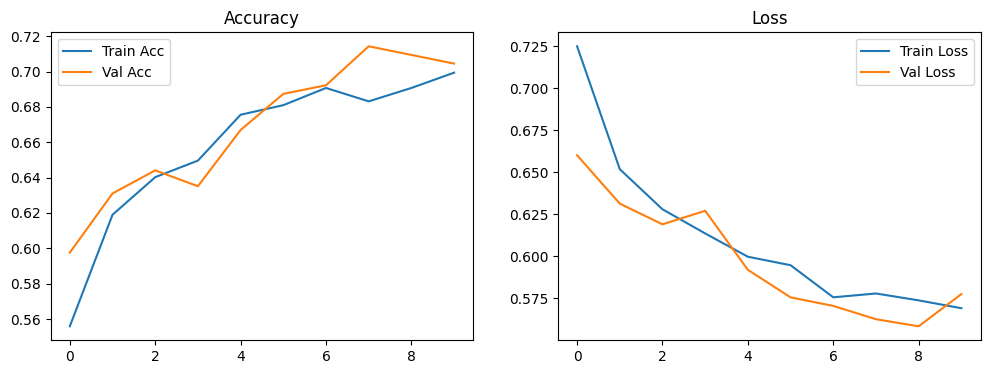

In [ ]:
# Training the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, # Starting with 10
    callbacks=callbacks
)

# Plotting Training Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

Testing on Held-out camera

Evaluating on Held-Out Camera (Test Set)...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7029 - loss: 0.5719
Test Accuracy: 0.7105
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
              precision    recall  f1-score   support

     blocked       0.50      0.36      0.42        11
  notblocked       0.77      0.85      0.81        27

    accuracy                           0.71        38
   macro avg       0.63      0.61      0.61        38
weighted avg       0.69      0.71      0.70        38



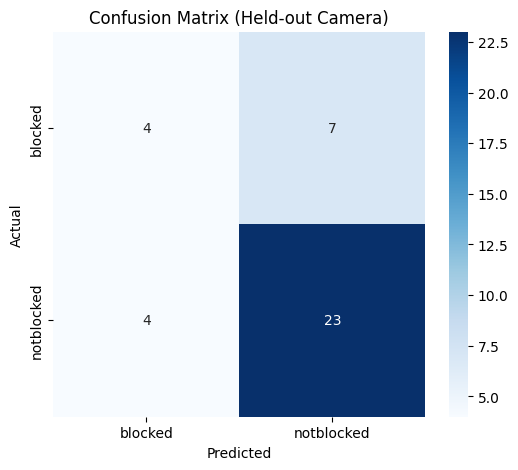

In [ ]:
print("Evaluating on Held-Out Camera (Test Set)...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate Predictions for Confusion Matrix
predictions = model.predict(test_ds)
y_pred = (predictions > 0.5).astype(int).flatten()

# Get True Labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=train_ds.class_names))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.class_names,
            yticklabels=train_ds.class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Held-out Camera)')
plt.show()

**Fine-Tuning:** Next we unfreeze the backbone and retrain with a significantly lower learning rate ($10^{-6}$) to allow the Transformer to adjust its feature extraction specifically for bike lane obstructions

In [ ]:
# Unfreeze the backbone
backbone.trainable = True

# Re-compile with a lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6), # Low LR
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train again (Fine-tuning phase)
# This allows the ViT to adjust its "vision" specifically for bike lanes
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 57s 299ms/step - accuracy: 0.7090 - loss: 0.5525 - val_accuracy: 0.7200 - val_loss: 0.5452
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - accuracy: 0.7216 - loss: 0.5434 - val_accuracy: 0.7282 - val_loss: 0.5366
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.7166 - loss: 0.5473 - val_accuracy: 0.7355 - val_loss: 0.5245
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.7387 - loss: 0.5187 - val_accuracy: 0.7396 - val_loss: 0.5173
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.7331 - loss: 0.5141 - val_accuracy: 0.7453 - val_loss: 0.5106
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.7441 - loss: 0.5072 - val_accuracy: 0.7502 - val_loss: 0.5035
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.7414 - loss: 0.5170 - val_accuracy: 0.7616 - val_loss: 0.4950
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.7493 - loss: 0.4940 - val_accu

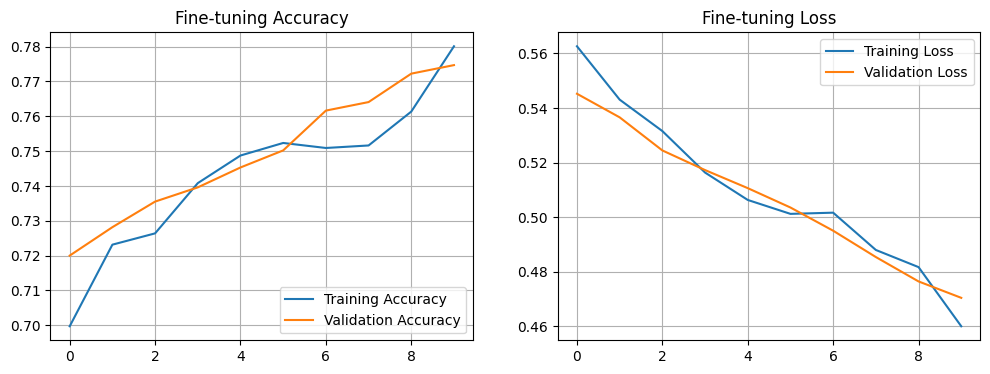

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Plot Training vs. Validation Graphs (Fine-tuning Phase)
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Fine-tuning Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Fine-tuning Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Evaluating Fine-tuned Model on Held-Out Camera...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7029 - loss: 0.5719

Fine-tuned Test Accuracy: 0.7105
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step

Classification Report:

              precision    recall  f1-score   support

     blocked       0.50      0.55      0.52        11
  notblocked       0.81      0.78      0.79        27

    accuracy                           0.71        38
   macro avg       0.65      0.66      0.66        38
weighted avg       0.72      0.71      0.71        38



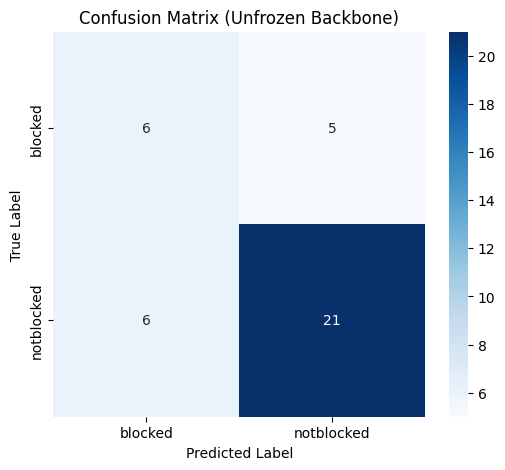

In [ ]:
# Evaluate on the Held-Out Camera (Test Set
print("\nEvaluating Fine-tuned Model on Held-Out Camera...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nFine-tuned Test Accuracy: {test_acc:.4f}")

# Generate Confusion Matrix & Classification Report
# Generate predictions
predictions = model.predict(test_ds)
y_pred = (predictions > 0.5).astype(int).flatten()

# Get true labels (extract from dataset)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Print Classification Report
class_names = train_ds.class_names
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Unfrozen Backbone)')
plt.show()

**Class Weights (Inverse Frequency)**
The model ignored the "blocked" class because it's easier to just guess "not blocked." Therefore, we can force the model to pay more attention to the blocked images by penalizing it more when it gets them wrong. Computed balanced class weights inversely proportional to their frequency (total / (2 * count)) to force the model to pay equal attention to the minority class.

In [ ]:
# Calculate weights (simplified logic: weight = total / (2 * count))
total = len(train_blocked) + len(train_notblocked)
weight_for_0 = (1 / len(train_blocked)) * (total / 2.0)
weight_for_1 = (1 / len(train_notblocked)) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6), # Low LR
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Pass this to model.fit
history_weighted = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights # NEW CLASS WEIGHTS HERE :)
)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 52s 247ms/step - accuracy: 0.7663 - loss: 0.4780 - val_accuracy: 0.7747 - val_loss: 0.4799
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.7654 - loss: 0.4594 - val_accuracy: 0.7780 - val_loss: 0.4716
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.7919 - loss: 0.4476 - val_accuracy: 0.7804 - val_loss: 0.4649
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.7928 - loss: 0.4414 - val_accuracy: 0.7780 - val_loss: 0.4682
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 293ms/step - accuracy: 0.7753 - loss: 0.4572 - val_accuracy: 0.7927 - val_loss: 0.4448
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 268ms/step - accuracy: 0.8099 - loss: 0.4230 - val_accuracy: 0.7935 - val_loss: 0.4432
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.7907 - loss: 0.4292 - val_accuracy: 0.7918 - val_loss: 0.4428
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.8039 - loss: 0.4296 - val_accu

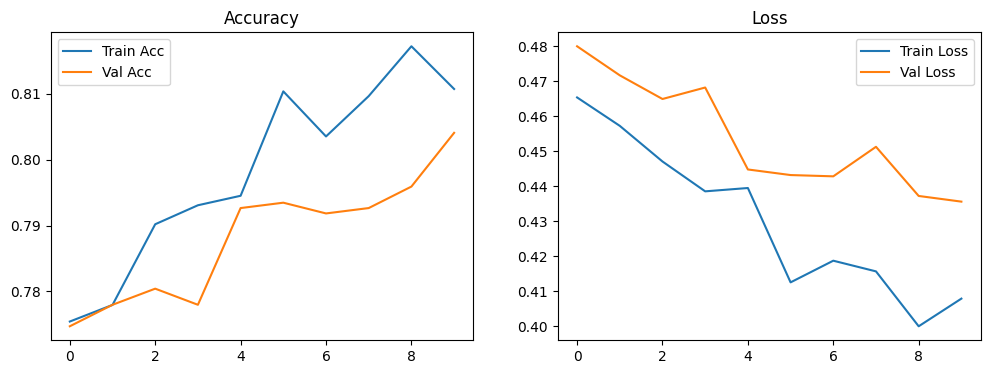

In [ ]:
# Plotting Training Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_weighted.history['accuracy'], label='Train Acc')
plt.plot(history_weighted.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_weighted.history['loss'], label='Train Loss')
plt.plot(history_weighted.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7204 - loss: 0.5616

weightedTest Accuracy: 0.7368


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step

Classification Report:

              precision    recall  f1-score   support

     blocked       0.54      0.64      0.58        11
  notblocked       0.84      0.78      0.81        27

    accuracy                           0.74        38
   macro avg       0.69      0.71      0.70        38
weighted avg       0.75      0.74      0.74        38



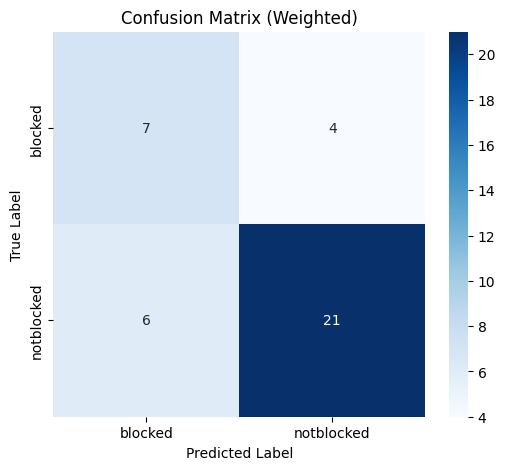

In [ ]:
# Evaluate on the Held-Out Camera (Test Set)

test_loss, test_acc = model.evaluate(test_ds)
print(f"\nweightedTest Accuracy: {test_acc:.4f}")

# Generate Confusion Matrix & Classification Report
# Generate predictions
predictions = model.predict(test_ds)
y_pred = (predictions > 0.5).astype(int).flatten()

# Get true labels (extract from dataset)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Print Classification Report
class_names = train_ds.class_names
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Weighted)')
plt.show()

**Manual Class Weights Method**
Defined subtle, manual weights (1.05 for 'blocked') to provide a boost to recall without sacrificing the precision achieved in previous steps

In [ ]:
# Define Subtle Class Weights
# give 'blocked' (0) a small 5% boost to encourage recall
# keeping 'notblocked' (1) at standard weight to maintain precision
class_weights = {0: 1.05, 1: 1.0}

print(f"Using Subtle Class Weights: {class_weights}")

# Re-compile to reset the optimizer state and start fresh
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6), # Keep low LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train again with the new weights
history_subtle = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights # NEW CLASS WEIGHTS HERE :)
)

Using Subtle Class Weights: {0: 1.05, 1: 1.0}
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 56s 288ms/step - accuracy: 0.8123 - loss: 0.4105 - val_accuracy: 0.8163 - val_loss: 0.4147
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.8196 - loss: 0.3974 - val_accuracy: 0.8082 - val_loss: 0.4045
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.8237 - loss: 0.3919 - val_accuracy: 0.8098 - val_loss: 0.3996
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.8200 - loss: 0.3855 - val_accuracy: 0.8171 - val_loss: 0.4028
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 270ms/step - accuracy: 0.8262 - loss: 0.3918 - val_accuracy: 0.8163 - val_loss: 0.3981
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.8277 - loss: 0.3816 - val_accuracy: 0.8212 - val_loss: 0.3996
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.8263 - loss: 0.3816 - val_accuracy: 0.8204 - val_loss: 0.3962
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/ste

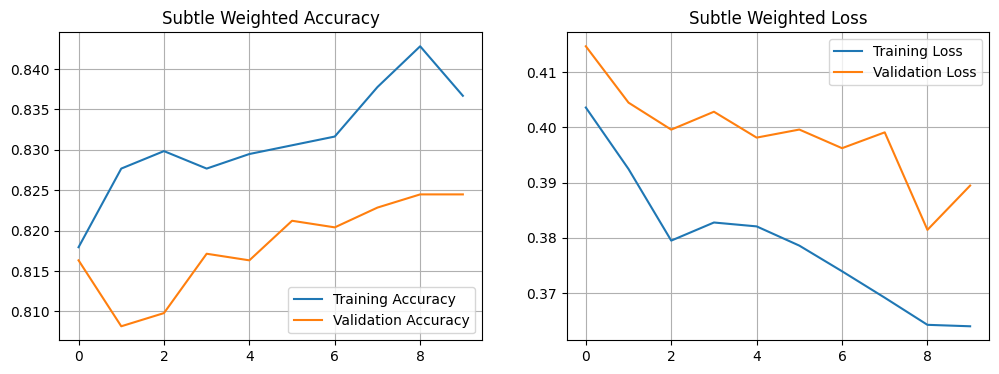

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot Training vs. Validation Graphs
acc = history_subtle.history['accuracy']
val_acc = history_subtle.history['val_accuracy']
loss = history_subtle.history['loss']
val_loss = history_subtle.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Subtle Weighted Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Subtle Weighted Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Evaluating Subtle Weighted Model on Held-Out Camera...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6749 - loss: 0.6038

Subtle Weighted Test Accuracy: 0.6842
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step

Classification Report:

              precision    recall  f1-score   support

     blocked       0.47      0.73      0.57        11
  notblocked       0.86      0.67      0.75        27

    accuracy                           0.68        38
   macro avg       0.66      0.70      0.66        38
weighted avg       0.75      0.68      0.70        38



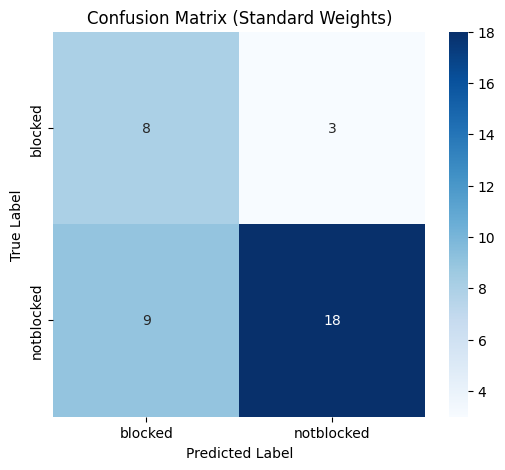

In [ ]:
print("\nEvaluating Subtle Weighted Model on Held-Out Camera...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nSubtle Weighted Test Accuracy: {test_acc:.4f}")

# Generate Predictions
predictions = model.predict(test_ds)
y_pred = (predictions > 0.5).astype(int).flatten()

# Get True Labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Classification Report
class_names = train_ds.class_names
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Standard Weights)')
plt.show()